In [2]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
# import some common libraries
import numpy as np
import torch
import os, json, cv2, random
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Dataset

In [5]:
import os
from PIL import Image
from collections import defaultdict
import pycocotools
from detectron2.structures import BoxMode


def build_kitti_mots_dicts(dataset_path, instances_ids=None):
    # Check that the dataset path exists and is a directory.
    assert os.path.isdir(dataset_path), f"Dataset path '{dataset_path}' is not a directory or does not exist."

    ann_dir = os.path.join(dataset_path, "instances_txt")
    images_folder = os.path.join(dataset_path, "training", "image_02")

    # Check that the annotation directory exists.
    assert os.path.isdir(ann_dir), f"Annotation directory '{ann_dir}' does not exist or is not a directory."
    # Check that the images folder exists.
    assert os.path.isdir(images_folder), f"Images folder '{images_folder}' does not exist or is not a directory."

    dataset_dicts = []
    # KITTI-MOTS Classes: Pedestrian (ID: 1) / Car (ID: 2) / Cyclist (ID: 3)
    # COCO Classes: Person (ID: 0) / Bicycle (ID: 1) / Car (ID: 2)
    category_map = {1: 0, 2: 2, 3: 1}

    # Iterate over each instance directory in the images folder.
    for instance_dir in sorted(os.listdir(images_folder)):
        instance_dir_path = os.path.join(images_folder, instance_dir)
        if not os.path.isdir(instance_dir_path):
            continue  # Skip non-directory entries

        try:
            instance_number = int(instance_dir)
        except ValueError:
            continue

        if instances_ids and instance_number not in instances_ids:
            continue

        instance_path = instance_dir_path
        ann_file = os.path.join(ann_dir, f"{instance_number:04d}.txt")
        
        annotations = defaultdict(list)
        if os.path.exists(ann_file):
            # Make sure ann_file is a file.
            assert os.path.isfile(ann_file), f"Annotation file '{ann_file}' exists but is not a file."
            with open(ann_file, "r") as file:
                for line in file:
                    parts = line.strip().split(" ")
                    # Validate that the annotation line has at least 6 parts.
                    if len(parts) < 6:
                        raise ValueError(f"Annotation line has less than 6 parts: {line}")
                    try:
                        time_frame = int(parts[0])
                        class_id = int(parts[2])
                        img_height = int(parts[3])
                        img_width = int(parts[4])
                    except ValueError:
                        raise ValueError(f"Annotation line contains non-integer values where expected: {line}")

                    # Validate that image dimensions are positive.
                    assert img_height > 0 and img_width > 0, f"Invalid image dimensions in annotation: {img_height}x{img_width}"

                    rle = parts[5].strip()
                    # Validate that RLE string is not empty.
                    assert rle, f"Empty RLE in annotation line: {line}"

                    # If the class id is 10, skip this annotation.
                    if class_id == 10:
                        continue

                    # Ensure that the class_id is in the category_map.
                    assert class_id in category_map, f"Class ID {class_id} is not in the category_map {category_map}"

                    mask = {"counts": rle, "size": [img_height, img_width]}
                    bbox = pycocotools.mask.toBbox(mask).tolist()
                    
                    """ IMPLEMENT IF SEGMENTATION IS NEEDED
                    # Convert to uint8 image for contour extraction.
                    segmentation = pycocotools.mask.decode(mask)
                    # Check that the segmentation mask dimensions match the expected image dimensions.
                    assert segmentation.shape[0] == img_height and segmentation.shape[1] == img_width, (
                        f"Segmentation shape {segmentation.shape} does not match expected dimensions [{img_height}, {img_width}]"
                    )
                    seg_uint8 = segmentation.astype(np.uint8)
                    contours, hierarchy = cv2.findContours(seg_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    # Ensure that at least one contour was found.
                    assert contours is not None and len(contours) > 0, f"No contours found in segmentation for annotation line: {line}"
                    polygons = [contour.flatten().tolist() for contour in contours if len(contour) >= 6]
                    # Ensure that at least one valid polygon exists.
                    assert len(polygons) > 0, f"No valid polygon (at least 3 points) found in annotation line: {line}"
                    """
                    polygons = []
                    
                    # Validate that the bounding box values are non-negative and have positive width/height.
                    x, y, w, h = bbox
                    assert x >= 0 and y >= 0 and w > 0 and h > 0, f"Invalid bbox values: {bbox}"

                    # Create a unique image ID
                    image_id = int(f"{instance_number:04d}{time_frame:06d}")

                    annotations[image_id].append({
                        "bbox": bbox,
                        "bbox_mode": BoxMode.XYWH_ABS,
                        "segmentation": polygons,
                        "category_id": category_map[class_id],
                    })

        # Check that the instance_path exists and is a directory.
        assert os.path.isdir(instance_path), f"Instance path '{instance_path}' is not a directory."
        image_files = sorted(os.listdir(instance_path))
        # Ensure that the instance directory contains image files.
        assert len(image_files) > 0, f"No image files found in instance directory '{instance_path}'."
        for img_file in image_files:
            # Process only valid image files based on extension.
            if not img_file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
                continue
            try:
                time_frame = int(os.path.splitext(img_file)[0])
            except ValueError:
                raise ValueError(f"Image filename '{img_file}' does not contain a valid integer time frame.")
            image_id = int(f"{instance_number:04d}{time_frame:06d}")
            file_path = os.path.join(instance_path, img_file)
            # Verify that the image file exists.
            assert os.path.isfile(file_path), f"Image file '{file_path}' does not exist or is not a file."
            # Open image and check dimensions.
            with Image.open(file_path) as img:
                width, height = img.size
                # Validate that the image dimensions are positive.
                assert width > 0 and height > 0, f"Image '{file_path}' has invalid dimensions: {width}x{height}"

            record = {
                "file_name": file_path,
                "image_id": image_id,
                "height": height,
                "width": width,
                "annotations": annotations[image_id],
            }
            dataset_dicts.append(record)

    # Final check: ensure that the dataset is not empty.
    assert len(dataset_dicts) > 0, "No data found in dataset, please check the dataset path and structure."
    return dataset_dicts

In [6]:
DatasetCatalog.register("kitti_mots", lambda: build_kitti_mots_dicts("/home/mcv/datasets/C5/KITTI-MOTS", instances_ids=[1, 2]))
MetadataCatalog.get("kitti_mots").set(thing_classes=["car", "bicycle", "person"])

dataset_dicts = build_kitti_mots_dicts("/home/mcv/datasets/C5/KITTI-MOTS")
kitti_mots_metadata = MetadataCatalog.get("kitti_mots")

### Visualize annotations

/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0015/000195.png {'file_name': '/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0015/000195.png', 'image_id': 15000195, 'height': 370, 'width': 1224, 'annotations': [{'bbox': [0.0, 230.0, 288.0, 140.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [447.0, 174.0, 56.0, 35.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [970.0, 160.0, 44.0, 98.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 2}, {'bbox': [991.0, 163.0, 28.0, 98.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 2}]}
classes: [0, 0, 2, 2]
class_names: ['car', 'bicycle', 'person']


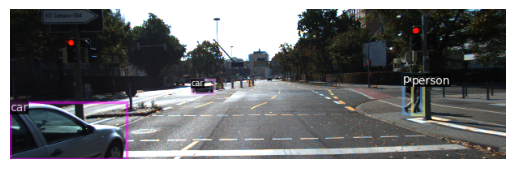

/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0003/000078.png {'file_name': '/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0003/000078.png', 'image_id': 3000078, 'height': 375, 'width': 1242, 'annotations': [{'bbox': [546.0, 180.0, 71.0, 63.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [20.0, 179.0, 103.0, 36.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}]}
classes: [0, 0]
class_names: ['car', 'bicycle', 'person']


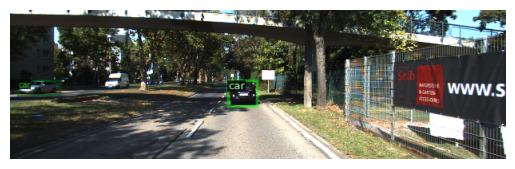

/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0001/000050.png {'file_name': '/home/mcv/datasets/C5/KITTI-MOTS/training/image_02/0001/000050.png', 'image_id': 1000050, 'height': 375, 'width': 1242, 'annotations': [{'bbox': [0.0, 205.0, 88.0, 170.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [470.0, 189.0, 60.0, 45.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [86.0, 199.0, 227.0, 112.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [358.0, 197.0, 75.0, 44.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [628.0, 182.0, 32.0, 24.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [521.0, 189.0, 26.0, 26.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}, {'bbox': [712.0, 172.0, 92.0, 30.0], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'segmentation': [], 'category_id': 0}

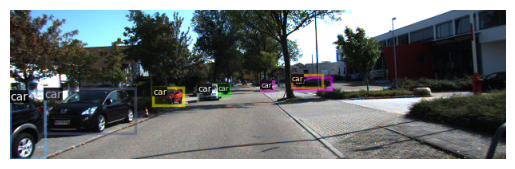

In [7]:
random.seed(42)
for d in random.sample(dataset_dicts, 3):
    print(d["file_name"], d)
    img = cv2.imread(d["file_name"])[:, :, ::-1]
    visualizer = Visualizer(img, metadata=kitti_mots_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

### Task (c): Run inference with pre-trained Faster R-CNN, DeTR and YOLOv(>8) on KITTI-MOTS dataset .

In [17]:
from detectron2.engine import DefaultPredictor

class CustomPredictor(DefaultPredictor):
    def __call__(self, original_image):
        outputs = super().__call__(original_image)
        instances = outputs["instances"]
        filtered_instances = self.filter_instances(instances)
        outputs["instances"] = filtered_instances
        return outputs

    def filter_instances(self, instances):
        """Keep only allowed classes: COCO class IDs (0=person, 2=car) and map to
        (0=person, 1=car)"""
        pred_classes = instances.pred_classes.tolist()
        keep = [i for i, cls in enumerate(pred_classes) if cls in [0, 1, 2]]
        filtered_instances = instances[keep]
        # {1: 0, 2: 2, 3: 1}
        mask_0 = filtered_instances.pred_classes == 0
        mask_1 = filtered_instances.pred_classes == 1
        filtered_instances.pred_classes[mask_0] = 0
        filtered_instances.pred_classes[mask_1] = 3
        return filtered_instances

In [18]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")
# Output folder
cfg.OUTPUT_DIR = "/ghome/c5mcv07/C5_G7_MCV/Task1/faster-rcnn/output/pre_trained_inference"
cfg.MODEL.DEVICE = device

[03/06 18:19:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_DC5_3x/137849425/model_final_68d202.pkl ...
classes: [2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2]
class_names: ['car', 'bicycle', 'person']


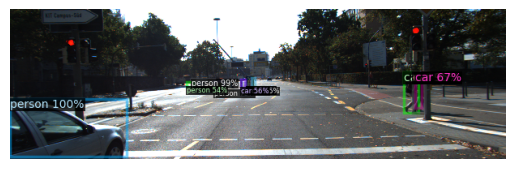

classes: [2, 2, 2, 2, 0]
class_names: ['car', 'bicycle', 'person']


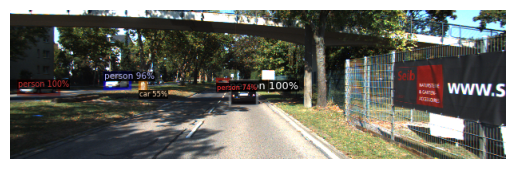

classes: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
class_names: ['car', 'bicycle', 'person']


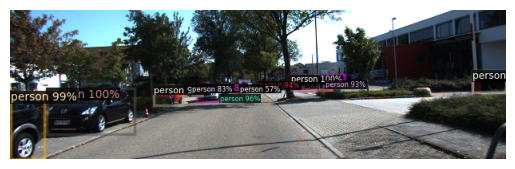

In [19]:
# Test inference
random.seed(42)
predictor = CustomPredictor(cfg)
for d in random.sample(dataset_dicts, 3):
    file_name = d["file_name"]
    image_id = d["image_id"]
    img = cv2.imread(file_name)[:, :, ::-1]
    outputs = predictor(img)  # Run inference
    instances = outputs["instances"]
    
    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img, kitti_mots_metadata, scale=0.5)
    out = v.draw_instance_predictions(instances.to("cpu"))
    plt.figure()
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

In [ ]:
# Run inference on all images
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

for d in random.sample(dataset_dicts, 3):
    file_name = d["file_name"]
    image_id = d["image_id"]
    folder, file = file_name.split("/")[-2:]
    os.makedirs(f"{cfg.OUTPUT_DIR}/{folder}_test", exist_ok=True)
    output_file = f"{cfg.OUTPUT_DIR}/{folder}_test/{file}"

    img = cv2.imread(file_name)[:, :, ::-1]
    outputs = predictor(img)  # Run inference

    # Filter predictions by class (keep only classes 0 -> person and 2 -> car)
    instances = outputs["instances"]
    classes = instances.pred_classes  # Get the predicted class IDs
    mask = torch.isin(classes, torch.as_tensor([0, 2]).to(device))  # Create a mask for classes 0 and 2
    filtered_instances = instances[mask]  # Apply the mask to filter instances
    pred_classes = filtered_instances.pred_classes
    pred_classes[pred_classes == 2] = 1  # Map car class to 1
    
    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img, kitti_mots_metadata, scale=1.2)
    out = v.draw_instance_predictions(filtered_instances.to("cpu"))
    cv2.imwrite(output_file, out.get_image())

### Task (d): Evaluate pre-trained Faster R-CNN, DeTR and YOLOv(>8) on KITTI-MOTS dataset.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("kitti_mots", output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "kitti_mots")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

### Task (e): Fine-tune Faster R-CNN, DeTR and YOLO on KITTI-MOTS (Similar Domain)

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ()
cfg.DATASETS.TEST = ("kitti_mots_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()